# Data Preparation

In [29]:
pip install TrilabytePyML --upgrade

  Attempting uninstall: TrilabytePyML
    Found existing installation: TrilabytePyML 1.0
    Uninstalling TrilabytePyML-1.0:
      Successfully uninstalled TrilabytePyML-1.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip list

Package                            Version           Location
---------------------------------- ----------------- ------------------------------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
arviz                              0.10.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt         

In [3]:
import pandas as pd

pd.options.mode.chained_assignment = None

frame = pd.read_csv('retail_unit_demand.csv')
display(frame)

,SKU,STORE_NUMBER,CAL_YEAR,CAL_MONTH,CAL_DATE,UNIT_DEMAND,PREDICTOR_1,PREDICTOR_2,PREDICTOR_3,PREDICTOR_4
0,1100,1150,2016,3,3/1/2016,16.0,1.856107,4.916073,6.350111,0.170545
1,1100,1150,2016,4,4/1/2016,28.0,9.803075,5.647253,40.128298,0.190157
2,1100,1150,2016,5,5/1/2016,35.0,3.598739,15.927959,29.807851,0.006683
3,1100,1150,2016,6,6/1/2016,129.0,1.155522,48.465667,17.236057,0.007743
4,1100,1150,2016,7,7/1/2016,179.0,9.673028,6.603080,39.144862,0.230874
...,...,...,...,...,...,...,...,...,...,...
113,1733,993243,2019,8,8/1/2019,NaN,5.563396,13.576681,12.819330,0.038417
114,1733,993243,2019,9,9/1/2019,NaN,6.663194,43.053491,11.374827,0.144381
115,1733,993243,2020,10,10/1/2020,NaN,2.270636,29.233220,59.000652,0.288833
116,1733,993243,2020,11,11/1/2020,NaN,4.903307,49.802078,27.008816,0.017463


# Forecast Options

In [4]:
options = dict()
options['method'] = 'Auto' #'Auto','MLR','ARIMA'
options['sortColumns'] = ['SKU','STORE_NUMBER','CAL_YEAR','CAL_MONTH']
options['splitColumns'] = ['SKU','STORE_NUMBER']
options['predictorColumns'] = ['PREDICTOR_1','PREDICTOR_2','PREDICTOR_3','PREDICTOR_4']
options['targetColumn'] = 'UNIT_DEMAND'
options['timestampColumn'] = 'CAL_DATE' #only needed by Prophet model  
options['periodicity'] = 12
options['autoDetectOutliers'] = True
options['outlierStdevMultiplier'] = 3.0
options['seasonalityBandwidth'] = 0.6
options['scalePredictors'] = True # MLR only; if true X_COEFFICIENTS become variable importances
options['ridgeAlpha'] = 1.0
options['forceNonNegative'] = True
options['seasonality'] = 'Auto' #'Auto','Additive','Multiplicative'
options['hypertune'] = False
options['numHoldoutRows'] = 6 # how may rows are used for holdout (MAPE calculation)

# Visualizations (first frame only)

In [5]:
# limit data to first combination (so that visualizations below work)
firstFrame = frame[frame['SKU'] == 1100].dropna()

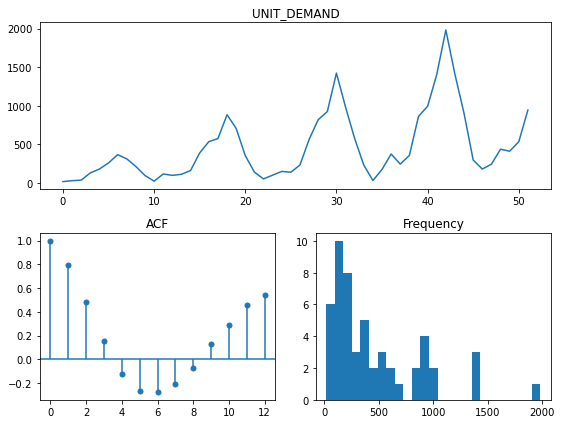

In [6]:
import pmdarima as pm

# Time Series Plot, ACF Plot and Histogram of Frequency
pm.tsdisplay(firstFrame[options['targetColumn']], lag_max=options['periodicity'], title=options['targetColumn'], show=True) 

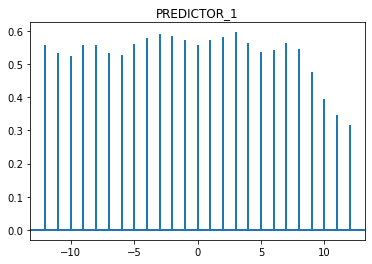

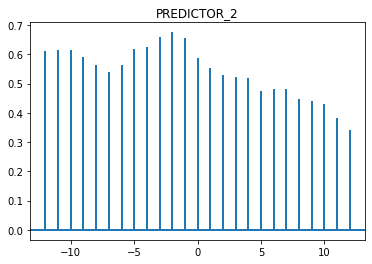

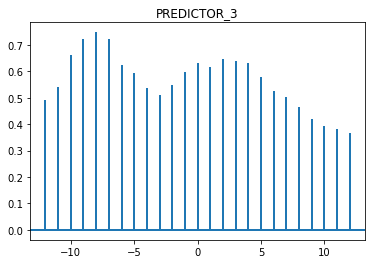

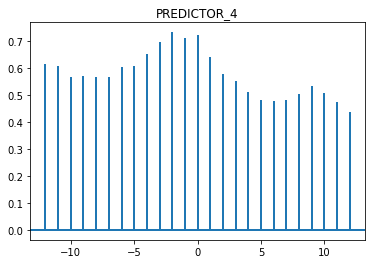

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for predCol in options['predictorColumns']:
    if (predCol != 'X_INDEX'):
        plt.xcorr(firstFrame[predCol], firstFrame[options['targetColumn']], usevlines=True, maxlags=options['periodicity'], normed=True, lw=2)
        plt.title(predCol)
        plt.show()

In [8]:
import seaborn as sns

def cross_correlation_heatmap(cc_df):
    # Credit to Bibor Szabo
    # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e
    
    plt.figure(figsize=(16, 6))

    mask = np.triu(np.ones_like(cc_df.corr(), dtype=np.bool))
    heatmap = sns.heatmap(cc_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Triangle Cross Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
    plt.savefig('cc_heatmap.png', dpi=300, bbox_inches='tight')
       
    return()

()

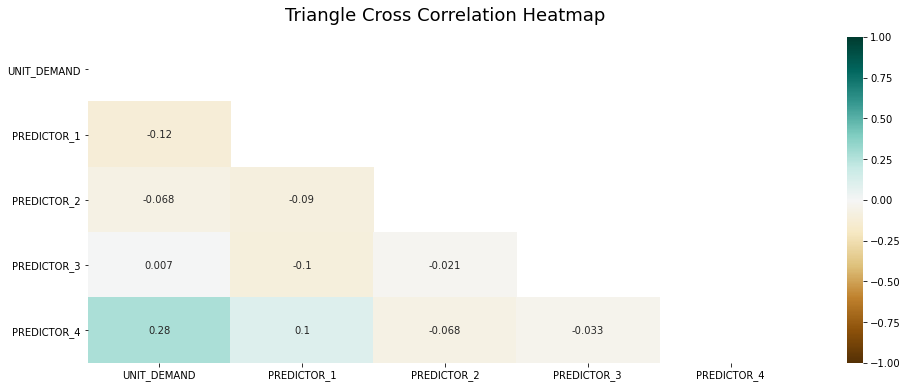

In [9]:
all_vars = [options['targetColumn']] + options['predictorColumns']
if ('X_INDEX' in all_vars):
    all_vars.remove('X_INDEX')
cross_correlation_heatmap(firstFrame[all_vars])

# Forecast Generation

In [10]:
import TrilabytePyML.AutoForecast as af

frame = af.splitFramesAndForecast(frame, options)

display(frame)

Importing plotly failed. Interactive plots will not work.


Auto MAPEs (MLR, ARIMA, Prophet, Ensemble):  [22.008751100434875, 68.00754917585428, 40.62232148180546, 30.36623252449864]
Auto MAPEs (MLR, ARIMA, Prophet, Ensemble):  [28.118194533068962, 76.28667536733396, 34.38750228283453, 24.183304079121474]


,SKU,STORE_NUMBER,CAL_YEAR,CAL_MONTH,CAL_DATE,UNIT_DEMAND,PREDICTOR_1,PREDICTOR_2,PREDICTOR_3,PREDICTOR_4,...,X_SEASONALITY_TYPE,X_FORECAST,X_MAPE,X_RESIDUAL,X_LPI,X_UPI,X_APE,X_HYPERTUNE,X_ERROR,X_METHOD
0,1100,1150,2016,3,3/1/2016,16.0,1.856107,4.916073,6.350111,0.170545,...,Additive,0.000000,22.008751,-66.896178,0.000000,285.711136,418.101110,None,None,MLR
1,1100,1150,2016,4,4/1/2016,28.0,9.803075,5.647253,40.128298,0.190157,...,Additive,0.000000,22.008751,-94.233347,0.000000,270.373967,336.547667,None,None,MLR
2,1100,1150,2016,5,5/1/2016,35.0,3.598739,15.927959,29.807851,0.006683,...,Additive,6.389654,22.008751,-28.610346,0.000000,342.996968,81.743845,None,None,MLR
3,1100,1150,2016,6,6/1/2016,129.0,1.155522,48.465667,17.236057,0.007743,...,Additive,284.777682,22.008751,155.777682,0.000000,621.384995,120.757893,None,None,MLR
4,1100,1150,2016,7,7/1/2016,179.0,9.673028,6.603080,39.144862,0.230874,...,Additive,484.974203,22.008751,305.974203,148.366889,821.581516,170.935309,None,None,MLR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,1733,993243,2019,8,8/1/2019,NaN,5.563396,13.576681,12.819330,0.038417,...,Multiplicative,1491.807882,24.183304,NaN,1304.905674,1678.710090,NaN,None,None,Ensemble
114,1733,993243,2019,9,9/1/2019,NaN,6.663194,43.053491,11.374827,0.144381,...,Multiplicative,1583.190704,24.183304,NaN,1492.460585,1934.253799,NaN,None,None,Ensemble
115,1733,993243,2020,10,10/1/2020,NaN,2.270636,29.233220,59.000652,0.288833,...,Multiplicative,1511.575853,24.183304,NaN,1391.509685,1765.314101,NaN,None,None,Ensemble
116,1733,993243,2020,11,11/1/2020,NaN,4.903307,49.802078,27.008816,0.017463,...,Multiplicative,864.048759,24.183304,NaN,799.187119,1002.010592,NaN,None,None,Ensemble


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


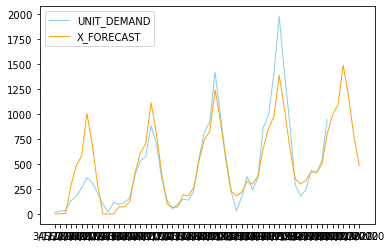

In [11]:
firstFrame = frame[frame['SKU'] == 1100]


plt.plot(options['timestampColumn'],options['targetColumn'], data=firstFrame, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=1)
plt.plot(options['timestampColumn'],'X_FORECAST', data=firstFrame, marker='', markerfacecolor='orange', markersize=12, color='orange', linewidth=1)
plt.legend()

In [12]:
frame.to_csv('output.csv')